# Tutorial: Workers' Safety Behavior in Construction Site

In this project, we are modeling and simulating workers’ safety behavior in the construction site. Workers’  safety behavior are categoried into two types: (1) safety risk adverse and (2) safety risk taking based on their risk preference when considering taking safety measures. We use Markov Chain Monte Carlo (MCMC) and dynamics on networks methods(Cellular Automata mainly) to study the system. The goal of the study is to observe the dynamics of the workers’ safety behaviors over a certain period of time.


* **[Part 0]**: Background of the topic 
* **[Part 1]**: This notebook is to simulate the change of workers' safety behavior with Markov Chain Monte Carlo (MCMC) method. 
* **[Part 2]**: This part explains how to use and implement dynamics on networks methods to study the workers' safety behavior in constuction site. The main dynamical model we apply to the network is Cellular Automata.

# Part 0: Background 

Construction site is one of the most dangerous workplaces due to its unique, dynamic and temporary natures.[1] Safety behavior of construction workers, which reflects the overall safety performance of a construction project is a significant focus in the area of construction safety management.

In this project, we categorize an individual worker’s  safety behavior into two types: (1) safety risk adverse and (2) safety risk taking. They are drawn based on worker’s risk preference when considering taking safety measures, like basic PPE, fall protection equipment, protective gloves, etc, Such a behavior can change over a certain period of time due to many factors.[2] Putting up all individual workers’ safety behaviors, we can see the safety behaviors of workers of a construction project as a whole. And the dynamics over a certain period of time can be simulated and possible conclusions regarding safety performance can be drawn from that. 

>[1] Al-Humaidi, H. M., & Tan, F. H. (2010). Construction safety in Kuwait. Journal of Performance of Constructed Facilities, 24(1), 70-77.

>[2] Mohammadi, A., Tavakolan, M., & Khosravi, Y. (2018). Factors influencing safety performance on construction projects: A review. Safety science, 109, 382-397.

# Part 1: Markov Chain Monte Carlo (MCMC) Model

This notebook is to simulate the change of workers' safety behavior with Markov Chain Monte Carlo (MCMC) method. 

## Setup

Run the following code cells to get started.

In [1]:
# Multidimensional array tool
import numpy as np

# Core plotting support
import matplotlib.pyplot as plt

# To implement pseudo-random number generators
import random

## Conceptual Model

Markov Chain Mote Carlo (MCMC) method is a stochastic model which enables us to simulate a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. With MCMC integration method, we can fit the models of virtually unlimited complexity because of its “memoryless” feature. [1]

In Markov Chain, we consider people's attitudes toward safety behaviors to be following certain probabilistic rules, which can be separated into safety risk adverse and safety risk taking. This is based on the assumption that everyone as an individual has his behavior patterns, or saying ‘habits’. For example, if a worker tends to avoid safety risk during the work, it would be much less likely for him to choose not to wear PPE at a certain timestep, we can make the probabilistic assumption that when transiting to another timestep, the probability of being safety risk adverse in the following state will be higher than the workers who get used to take safety risk. 

Basically, we need to define a matrix to describe the status for each timestep and randomly generate a matrix to represent the initial state. After that, we need to construct a probability transition matrix $P = [p_{ij}]$ where $p_i = Pr[i|j]$ is the conditional probability of state $i$ given the previous state $j$. 

Consider the two states mentioned above (safety risk adverse and safety risk taking), we can make an assumption on the transit matrix to simulate the probability of wearing safety equipment for each worker based on the behaviors in the former state. In sum, we can evaluate the overall safety level regarding workers’ behavior among all the time states.

> [1] Carlin, B. P., & Chib, S. (1995), [Bayesian Model Choice via Markov Chain Monte Carlo Methods](https://www.jstor.org/stable/2346151?seq=1#metadata_info_tab_contents)_ (Journal of the Royal Statistical Society. Series B (Methodological), 473-484).

First of all, let's associate the two possible states with the following integers:

In [2]:
RISK_ADVERSE = 0
RISK_TAKING = 1

## Markov Process

To simulate a Markov process, we can define a class named 'MarkovChain'.

In [3]:
class MarkovChain(object):

    def __init__(self, transit_prob):
    	"""
    	Initialize the Markov Chain model.

    	Parameters
    	---------- 
    	transit_prob: dict 
            A dict representing the transit matrix of the system.
    	    e.g. {'state1': {'state1': 0.5, 'state2': 0.5}, 
    	          'state2': {...}}
    	"""
    	self.transit_prob = transit_prob
    	self.states = list(transit_prob.keys())
 		
    def next_state(self, current_state):
        """
        Returns the new state at the next timestep.

        Parameters
        ----------
        current_state: str or int
            Current state of the system.
            e.g. 'RISK_ADVERSE' or 0
        """
        return np.random.choice(self.states, 
            p = [self.transit_prob[current_state][next_state]
            for next_state in self.states])

    def generate_states(self, current_state, K):
        """
        Generate the new state of the system after K timesteps.

        Parameters
        ----------
        current_state: str or int
            Current state of the system.
            e.g. 'RISK_ADVERSE' or 0

        K: int
            The number of timesteps.
        """
        future_states = []

        for k in range(K):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state

        return future_states

## Markov Chain Monte Carlo (MCMC) Simulation Preprocessing

The following code cell contains a few functions defined to help implement the MCMC method for workers' safety behavior model. 

In [4]:
def count(G):
	"""
	Count the number of elements of a NumPy array G 
	whose entries are 1.
	"""
	return len(np.where(G)[0])

def find(G):
	"""
	Returns the locations of elements of a NumPy array G 
	whose entries are 1.
	"""
	assert type(G) is np.ndarray
	return {i for i in np.where(G)[0]}

def risk_adverse(G):
	"""
	Return a new grid whose entries are 1 
	wherever the original grid in G is RISK_ADVERSE 
	or 0 otherwise.
	"""
	return (G == RISK_ADVERSE).astype(int)

def risk_taking(G):
	"""
	Return a new grid whose entries are 1
	wherever the original grid in G is RISK_TAKING
	or 0 otherwise.
	"""
	return (G == RISK_TAKING).astype(int)

def sim(G, prob, K):
	"""
	Simulate a Markov Chain system.

	Parameters
	----------
	G: NumPy array
		A NumPy array representing the starting state of workers.

	prob: dict
		A dict representing the transit matrix of the system.

	N: int
		The number of workers.

	K: int
		The number of timesteps.
	"""
	assert type(G) is np.ndarray

	chain = MarkovChain(transit_prob=prob)

	N = G.shape[0]

	for n in range(N):
		G[n] = chain.generate_states(current_state=G[n], K=K)[K - 1]

	return G

**Test 1**

Based on the framework above, we can set a transit matrix to simulate a 100-worker system with 200 timesteps in the first test and visualize the change of percentages along with the timesteps afterwards.

In this case, we let the transit matrix be: 

T_MAT $= \left[\begin{array}{ccc}
    0.8 & 0.2 \\
    0.4 & 0.6
\end{array}\right]$

In [5]:
# Customized transit matrix (dict)
T_MAT = {0: {0: 0.8, 1: 0.2}, 
         1: {0: 0.4, 1: 0.6}}

# Total number of workers
WORKER_NUM = 100

# Total number of timesteps to simulate
TIMESTEP = 200

Run the Markov process. Calculate and save the percentage numbers for two behaviors at different timesteps.

In [6]:
# Create two NumPy arrays to save the results for both risk adverse workers and risk taking workers
percent_risk_adverse = np.zeros(TIMESTEP, dtype=float)
percent_risk_taking = np.zeros(TIMESTEP, dtype=float)

### BEGIN SIMULATION

for i in range(TIMESTEP):
	if i == 0:
		workers = np.random.randint(2, size=WORKER_NUM)
	else:
		workers = sim(G=workers, prob=T_MAT, K=1)

	percent_risk_adverse[i] = 1e2 * count(risk_adverse(workers)) / WORKER_NUM
	percent_risk_taking[i] = 1e2 * count(risk_taking(workers)) / WORKER_NUM

### END SIMULATION

In [7]:
print(percent_risk_adverse)
print(percent_risk_taking)

[48. 61. 63. 66. 65. 65. 65. 68. 71. 66. 72. 68. 72. 66. 65. 72. 74. 72.
 75. 69. 62. 67. 66. 67. 72. 72. 61. 70. 67. 64. 63. 68. 72. 61. 62. 70.
 67. 61. 60. 69. 69. 60. 65. 68. 76. 75. 67. 71. 68. 75. 70. 64. 62. 68.
 66. 64. 60. 59. 57. 68. 65. 71. 69. 68. 74. 69. 66. 68. 65. 69. 71. 74.
 63. 57. 62. 69. 66. 68. 72. 74. 71. 74. 75. 69. 63. 66. 62. 63. 65. 62.
 71. 67. 67. 72. 69. 68. 59. 68. 68. 66. 76. 71. 63. 56. 63. 65. 66. 63.
 74. 69. 61. 70. 70. 67. 66. 68. 65. 72. 68. 65. 70. 72. 70. 64. 61. 70.
 70. 60. 61. 66. 62. 69. 64. 74. 76. 71. 61. 66. 65. 74. 63. 61. 64. 67.
 67. 71. 64. 74. 67. 63. 62. 60. 58. 66. 64. 67. 68. 66. 65. 65. 70. 74.
 74. 77. 72. 76. 67. 64. 67. 56. 57. 58. 61. 59. 61. 58. 68. 63. 67. 69.
 67. 68. 62. 60. 67. 71. 71. 73. 72. 68. 64. 70. 67. 59. 65. 59. 71. 68.
 68. 69.]
[52. 39. 37. 34. 35. 35. 35. 32. 29. 34. 28. 32. 28. 34. 35. 28. 26. 28.
 25. 31. 38. 33. 34. 33. 28. 28. 39. 30. 33. 36. 37. 32. 28. 39. 38. 30.
 33. 39. 40. 31. 31. 40. 35. 32. 24. 25. 

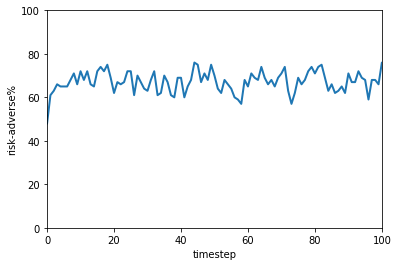

In [8]:
# Visualize the change of percentages of safety risk adverse workers
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(percent_risk_adverse, lw=2)

plt.xlim((0, 100))
plt.ylim((0, 100))
plt.xlabel('timestep')
plt.ylabel('risk-adverse%')

plt.show()

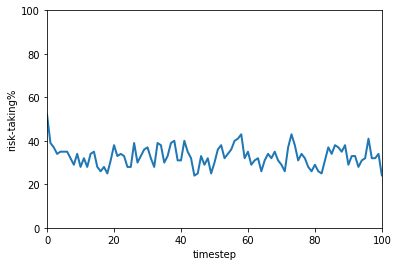

In [9]:
# Visualize the change of percentages of safety risk taking workers
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(percent_risk_taking, lw=2)

plt.xlim((0, 100))
plt.ylim((0, 100))
plt.xlabel('timestep')
plt.ylabel('risk-taking%')

plt.show()

From above, we can see that the percentages of two kinds of workers both fluctuate around a certain level. In order to specify the levels, we can run the simulation for 100 times and calculate the mean value of final percentage numbers as follow:

In [10]:
SIM_NUM = 100

num_risk_adverse = np.zeros(SIM_NUM, dtype=int)
num_risk_taking = np.zeros(SIM_NUM, dtype=int)


### BEGIN SIMULATION

for i in range(SIM_NUM):

	# Randomly enerate a NumPy array to represent the starting state of all the workers
	workers = np.random.randint(2, size=WORKER_NUM)

	G = sim(G=workers, prob=T_MAT, K=TIMESTEP)

	num_risk_adverse[i] = count(risk_adverse(G))
	num_risk_taking[i] = count(risk_taking(G))

### END SIMULATION

# Calculate the percentages
print("Safety-risk-adverse: {:.1f}%".format(1e2 * np.mean(num_risk_adverse) / WORKER_NUM))
print("Safety-risk-taking: {:.1f}%".format(1e2 * np.mean(num_risk_taking) / WORKER_NUM))

Safety-risk-adverse: 66.7%
Safety-risk-taking: 33.3%


In [11]:
# Chekc if the number of risk adverse workers plus that of risk taking ones equals to the total number.
assert (num_risk_adverse + num_risk_taking == WORKER_NUM).all()
print("PASS")

PASS


**Test 2**

From the result of Test 1, we can find that the percentage numbers tend to fluctuate around a certain level, i.e. the mean value. It is reasonable to point out the question: is it starting state or transit matrix that affects the mean value of percentage numbers? 

Therefore, we set up the second test.

Setting the probability of safety-risk-taking to be 0.2 in the starting state, simulate the system and calculate the percentages of two different workers. 

In [12]:
# The probability of a single worker to be risk-taking at the starting timestep
p = 0.2

# Initialize
num_risk_adverse = np.zeros(SIM_NUM, dtype=int)
num_risk_taking = np.zeros(SIM_NUM, dtype=int)


def random_pick(value_list, prob):
    """
    Return a value in the value_list in accordance to the corresponding probability.
    
    Parameters
    ----------
    value_list: list
        A list comprising all the possible values.
        e.g. [0, 1, 2, 3]
    
    prob: tuple
        A tuple comprising the appearing probability corresponding to value_list.
        e.g. (0.1, 0.4, 0.2, 0.3)
    """
    x = random.uniform(0, 1)
    sum_prob = 0.0
    for item, item_prob in zip(value_list, prob):
        sum_prob += item_prob
        if x < sum_prob:
            break
    return item


### BEGIN SIMULATION

for i in range(SIM_NUM):

    W = np.zeros(WORKER_NUM, dtype=int)
    
    # Generate a NumPy array to represent the starting state, given the probability of 1 as 0.2
    for j in range(WORKER_NUM):
        W[j] = random_pick([0, 1], (1-p, p))
        
    G = sim(G=W, prob=T_MAT, K=TIMESTEP)

    num_risk_adverse[i] = count(risk_adverse(G))
    num_risk_taking[i] = count(risk_taking(G))

### END SIMULATION


# Calculate the percentages
print("Safety-risk-adverse: {:.1f}%".format(1e2 * np.mean(num_risk_adverse) / WORKER_NUM))
print("Safety-risk-taking: {:.1f}%".format(1e2 * np.mean(num_risk_taking) / WORKER_NUM))

Safety-risk-adverse: 66.6%
Safety-risk-taking: 33.4%


Shown as the results in Test 2, the percentage numbers of both kinds of workers are actually the same as the previous test, which leads us to focus on the transit matrix.

Suppose the transit matrix of the system to be $\left[\begin{array}{ccc}
    0.2 & 0.8 \\
    0.3 & 0.7
\end{array}\right]$, simulate the system and calculate the percentages of two different workers again. 

In [13]:
T_MAT = {0: {0: 0.2, 1: 0.8}, 
         1: {0: 0.3, 1: 0.7}}

# Initialize
num_risk_adverse = np.zeros(SIM_NUM, dtype=int)
num_risk_taking = np.zeros(SIM_NUM, dtype=int)


### BEGIN SIMULATION

for i in range(SIM_NUM):

    W_prime = np.random.randint(2, size=WORKER_NUM)
    
    G = sim(G=W_prime, prob=T_MAT, K=TIMESTEP)

    num_risk_adverse[i] = count(risk_adverse(G))
    num_risk_taking[i] = count(risk_taking(G))

### END SIMULATION


# Calculate the percentages
print("Safety-risk-adverse: {:.1f}%".format(1e2 * np.mean(num_risk_adverse) / WORKER_NUM))
print("Safety-risk-taking: {:.1f}%".format(1e2 * np.mean(num_risk_taking) / WORKER_NUM))

Safety-risk-adverse: 27.1%
Safety-risk-taking: 72.8%


Based on the results of both Test 1 and Test 2, we may draw a conclusion that the mean value of percentage numbers is mainly decided by the transit matrix. 

Furthermore, suppose the transit matrix is $T^{2\times 2}$, the mean value of risk adverse workers $(0)$ is $\frac{T_{11} + T_{21}}{2}$ and that of risk taking workers $(1)$ is $\frac{T_{12} + T_{22}}{2}$